In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
from torchvision.transforms import RandomErasing
from torch.utils.data import ConcatDataset


batch_multi = 2

def load_flowers102():
    transformTrain1 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # New affine transformation
    #transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # More aggressive blurring
    transforms.ToTensor(),
    #RandomErasing(0.5, (0.02, 0.33)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    transformTrain2 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # New affine transformation
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # More aggressive blurring
    transforms.ToTensor(),
    #RandomErasing(0.5, (0.02, 0.33)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    transformTrain3 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(80),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # New affine transformation
    #transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # More aggressive blurring
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),

    transforms.ToTensor(),
    RandomErasing(0.5, (0.02, 0.33)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


    transformTest = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


    train_dataset1 = torchvision.datasets.Flowers102(root='flowers102data', split='train', download=True, transform=transformTrain1)
    train_dataset2 = torchvision.datasets.Flowers102(root='flowers102data', split='train', download=True, transform=transformTrain2)
    train_dataset3 = torchvision.datasets.Flowers102(root='flowers102data', split='train', download=True, transform=transformTrain3)
    train_dataset = ConcatDataset([train_dataset1, train_dataset2, train_dataset3])
    test_dataset = torchvision.datasets.Flowers102(root='flowers102data', split='test', download=True, transform=transformTest)
    validation_dataset = torchvision.datasets.Flowers102(root='flowers102data', split='val', download=True, transform=transformTest)

    train_loader = DataLoader(train_dataset, batch_size=32 * batch_multi, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32 * batch_multi, shuffle=False)
    validation_loader = DataLoader(validation_dataset, batch_size=32 * batch_multi, shuffle=False)

    return train_loader, test_loader, validation_loader


In [3]:
def set_device():
    if torch.cuda.is_available():
      print('cuda')
      return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu") 


device = set_device()


In [4]:
class simpleCNN(nn.Module):
    def __init__(self):
        super(simpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.35)
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)  
        self.fc2 = nn.Linear(1024, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [5]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, patience=5, num_epochs=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    current_patience = 0

    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0

        # Training phase
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation phase
        model.eval()
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(validation_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}: Training Loss = {avg_train_loss}, Validation Loss = {avg_val_loss}')


        scheduler.step(avg_val_loss)

        current_lr = scheduler.optimizer.param_groups[0]['lr']
        print(f"Current Learning Rate: {current_lr}")


        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            current_patience = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            current_patience += 1
            if current_patience >= patience:
                print("Early stopping triggered!")
                break


    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model


In [6]:
def test_model(model, test_loader):
    model.eval()  
    total_correct = 0
    total_images = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_images += labels.size(0)
    print(f'Accuracy: {total_correct / total_images * 100:.2f}%')

100%|██████████| 344862509/344862509 [00:27<00:00, 12617850.89it/s]


Extracting flowers102data/flowers-102/102flowers.tgz to flowers102data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 249886.14it/s]


100%|██████████| 14989/14989 [00:00<00:00, 3231146.77it/s]


Epoch 1: Training Loss = 4.446133057276408, Validation Loss = 3.9672600477933884
Current Learning Rate: 0.0001
Epoch 2: Training Loss = 4.017709712187449, Validation Loss = 3.6560655534267426
Current Learning Rate: 0.0001
Epoch 3: Training Loss = 3.807481770714124, Validation Loss = 3.4620314836502075
Current Learning Rate: 0.0001
Epoch 4: Training Loss = 3.6307987620433173, Validation Loss = 3.3118169605731964
Current Learning Rate: 0.0001
Epoch 5: Training Loss = 3.5053589195013046, Validation Loss = 3.198935389518738
Current Learning Rate: 0.0001
Epoch 6: Training Loss = 3.3665454337994256, Validation Loss = 3.043142259120941
Current Learning Rate: 0.0001
Epoch 7: Training Loss = 3.252961074312528, Validation Loss = 3.012982591986656
Current Learning Rate: 0.0001
Epoch 8: Training Loss = 3.1363229155540466, Validation Loss = 2.953942723572254
Current Learning Rate: 0.0001
Epoch 9: Training Loss = 3.028116842110952, Validation Loss = 2.8818661272525787
Current Learning Rate: 0.0001
E

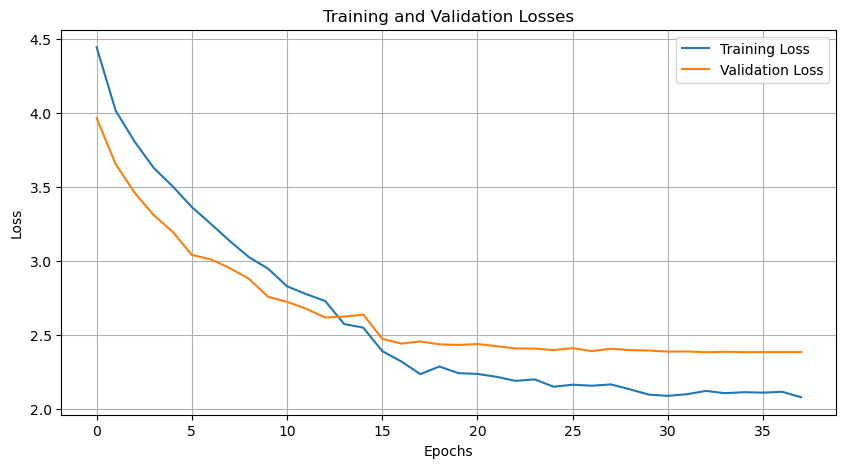

simpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.35, inplace=False)
  (fc1): Linear(in_features=100352, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=102, bias=True)
)

In [7]:

model = simpleCNN()
model.to(device)  
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

train_loader, test_loader, validation_loader = load_flowers102()
train_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, patience=5, num_epochs=200)


In [9]:
model = simpleCNN()
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

simpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.35, inplace=False)
  (fc1): Linear(in_features=100352, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=102, bias=True)
)

In [10]:
test_model(model, test_loader)

Accuracy: 37.50%


In [ ]:
from PIL import Image
import torchvision.transforms as transforms

def test_single_image(model, image_path, transform):
    model.eval()  
    image = Image.open(image_path)  
    image = transform(image).unsqueeze(0)  
    image = image.to(device)  

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)  
    return predicted.item()

In [ ]:
image_path = 'flowers102data/flowers-102/jpg/image_05954.jpg'
transformTest = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
model.to(device)  
predicted_class = test_single_image(model, image_path, transformTest)
print(f'Predicted Class: {predicted_class}')


import os
from scipy.io import loadmat


image_directory = 'flowers102data/flowers-102/jpg'
label_file = 'imagelabels.mat'


image_files = sorted(os.listdir(image_directory))


labels_mat = loadmat(label_file)



image_name = os.path.basename(image_path)


image_index = image_files.index(image_name)

actual_label = labels[image_index] -1
print(f'Actual Class for {image_name}: {actual_label}')

Predicted Class: 18
Actual Class for image_05954.jpg: 67
